### Plasma Sheath, Cylindrical Langmuir Probe, Radial model

First, we set the kind of plasma. Uncomment the line that corresponds

In [1]:
import initialize

bg = initialize.BetaGammaSheath()
bg.x_array = []
bg.y_array = []
bg.z_array = []
bg.N_array = []

Positive ion mass = 39.948 and Negative ion mass = 0.00054858


Text(value='')

<IPython.core.display.Javascript object>


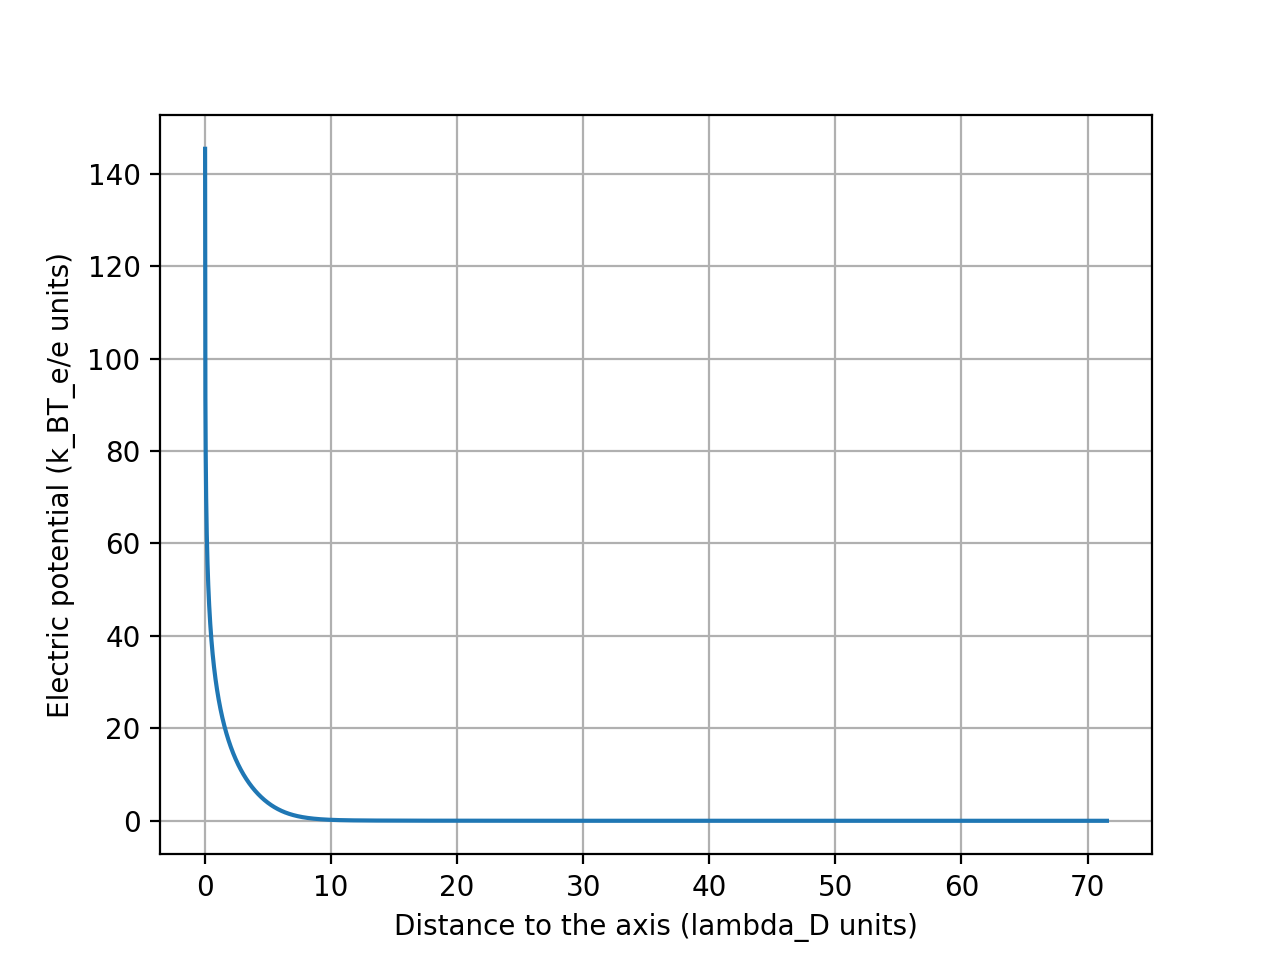

In [2]:
import sheath
from ipywidgets import widgets
import matplotlib.pyplot as plt
%matplotlib notebook

# Display sliders and options

beta_slider = widgets.FloatSlider(value=0.1, min=0.0, max=1.0, step=0.01, description='beta:')
gamma_slider = widgets.FloatSlider(value=10, min=1.0, max=100.0, step=0.1, description='gamma:')
alpha0_slider = widgets.FloatSlider(value=0.5, min=0.0, max=10.0, step=0.1, description='alpha0:')
#beta_slider = widgets.FloatSlider(value=0.1, min=0.0, max=1.0, step=0.01, description='beta:')

sliders = widgets.VBox([beta_slider, gamma_slider, alpha0_slider])
display(sliders)

run_button = widgets.Button(description = "Run calculation")
quasi_button = widgets.Button(description = "Quasineutral solution", disabled = True)
run_plot_buttons = widgets.HBox([run_button])

display(run_plot_buttons)

info_text = widgets.Text()
display(info_text)

fig, ax = plt.subplots()  # Create a figure containing a single axes.
def set_plot_figure(ax):
    ax.set(xlabel='Distance to the axis (lambda_D units)', ylabel='Electric potential (k_BT_e/e units)')
    ax.grid()

set_plot_figure(ax)

def run_button_clicked(b):
    '''Helper function to pass arguments'''
    info_text.value = "Calculation in progress"
    
    # Pass parameters to bg
    global bg
    bg.g.beta = beta_slider.value
    bg.g.gamma = gamma_slider.value
    bg.g.alpha0 = alpha0_slider.value
    sheath.cylindrical(bg)
    info_text.value = "Calculation finished"
    
    # Plot according to given options
    plt.cla()
    set_plot_figure(ax)
    ax.plot(bg.x_array, bg.y_array)
    
run_button.on_click(run_button_clicked)

